In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [4]:
iris = datasets.load_iris()
num_pts = len(iris.data)
num_feats = len(iris.data[0])

In [5]:
with tf.Session() as sess:
    k = 3
    generations = 25
    data_points = tf.Variable(iris.data)
    cluster_labels = tf.Variable(tf.zeros([num_pts], dtype=tf.int64))
    
    rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)])
    centroids = tf.Variable(rand_starts)
    
    centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), [num_pts, k, num_feats])
    point_matrix = tf.reshape(tf.tile(data_points, [1, k]), [num_pts, k, num_feats])
    distances = tf.reduce_sum(tf.square(point_matrix - centroid_matrix), axis=2)
    
    centroid_group = tf.argmin(distances, 1)
    
    def data_group_avg(group_ids, data):
        sum_total = tf.unsorted_segment_sum(data, group_ids, 3)
        num_total = tf.unsorted_segment_sum(tf.ones_like(data), group_ids, 3)
        avg_by_group = sum_total / num_total
        return avg_by_group
    
    means = data_group_avg(centroid_group, data_points)
    update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(generations):
        print('Calculating gen {}, out of {}.'.format(i, generations))
        _, centroid_group_count = sess.run([update, centroid_group])
        group_count = []
        for ix in range(k):
            group_count.append(np.sum(centroid_group_count == ix))
        print('Group counts: {}'.format(group_count))
    
    [centers, assignments] = sess.run([centroids, cluster_labels])
    
    def most_common(my_list):
        return max(set(my_list), key=my_list.count)
    
    label0 = most_common(list(assignments[0:50]))
    label1 = most_common(list(assignments[50:100]))
    label2 = most_common(list(assignments[100:150]))

    group0_count = np.sum(assignments[0:50] == label0)
    group1_count = np.sum(assignments[50:100] == label1)
    group2_count = np.sum(assignments[100:150] == label2)

    accuracy = (group0_count + group1_count + group2_count) / 150.
    print('Accuracy: {:.2}'.format(accuracy))

Calculating gen 0, out of 25.
Group counts: [36, 73, 41]
Calculating gen 1, out of 25.
Group counts: [58, 55, 37]
Calculating gen 2, out of 25.
Group counts: [62, 51, 37]
Calculating gen 3, out of 25.
Group counts: [62, 50, 38]
Calculating gen 4, out of 25.
Group counts: [62, 50, 38]
Calculating gen 5, out of 25.
Group counts: [62, 50, 38]
Calculating gen 6, out of 25.
Group counts: [62, 50, 38]
Calculating gen 7, out of 25.
Group counts: [62, 50, 38]
Calculating gen 8, out of 25.
Group counts: [62, 50, 38]
Calculating gen 9, out of 25.
Group counts: [62, 50, 38]
Calculating gen 10, out of 25.
Group counts: [62, 50, 38]
Calculating gen 11, out of 25.
Group counts: [62, 50, 38]
Calculating gen 12, out of 25.
Group counts: [62, 50, 38]
Calculating gen 13, out of 25.
Group counts: [62, 50, 38]
Calculating gen 14, out of 25.
Group counts: [62, 50, 38]
Calculating gen 15, out of 25.
Group counts: [62, 50, 38]
Calculating gen 16, out of 25.
Group counts: [62, 50, 38]
Calculating gen 17, out 

In [6]:
pca_model = PCA(n_components=2)
reduced_data = pca_model.fit_transform(iris.data)
reduced_centers = pca_model.transform(centers)

h = .02

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xx_pt = list(xx.ravel())
yy_pt = list(yy.ravel())
xy_pts = np.array([[x, y] for x, y in zip(xx_pt, yy_pt)])
mytree = cKDTree(reduced_centers)
dist, indexes = mytree.query(xy_pts)

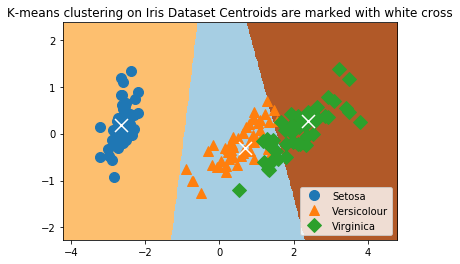

In [7]:
indexes = indexes.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(indexes, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

symbols = ['o', '^', 'D']
label_name = ['Setosa', 'Versicolour', 'Virginica']
for i in range(3):
    temp_group = reduced_data[(i*50):(50)*(i+1)]
    plt.plot(temp_group[:, 0], temp_group[:, 1], symbols[i], markersize=10, label=label_name[i])

plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
plt.title('K-means clustering on Iris Dataset Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='lower right')
plt.show()